# Import and configurations

In [1]:
from nyuv2_dataset import NYUv2Dataset
from cityscapes_dataset import CityscapesDataset
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from cross_stitchnet import CrossStitchNet
from densenet import DenseNet
from depthnet import DepthNet
from splitnet import SplitNet
from stan import STAN
from mtan import MTAN
from segnet import SegNet
from normalnet import NormalNet
from trainer import Trainer
from utils import count_params, visualize_results

2025-03-26 16:52:57.401552: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-26 16:52:57.439135: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-26 16:52:58.109626: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
dataset_string = 'cityscapes'
tasks = ['segmentation', 'depth'] if dataset_string == 'cityscapes' else ['segmentation', 'depth', 'normal']
depth_activation = nn.ReLU() if dataset_string == 'cityscapes' else nn.Sigmoid()
BATCH_SIZE = 8 if dataset_string == 'cityscapes' else 2
LR = 1e-4
filter = [64, 128, 256, 512, 512] 

In [3]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:1


# Data Loading

In [4]:
if dataset_string == 'nyuv2':
    print("NYUv2 Dataset")
    nyuv2_train = NYUv2Dataset(root="../dataset/nyuv2_preprocessed", split='train')
    classes = nyuv2_train.get_classes()

    nyuv2_val = NYUv2Dataset(root="../dataset/nyuv2_preprocessed", split='val')
    train_dl = DataLoader(nyuv2_train, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(nyuv2_val, batch_size=BATCH_SIZE, shuffle=False)

    for image, out in train_dl:
        print('Image: ' + str(list(image.shape)) + ',' + ' Label: ' + str(list(out['segmentation'].shape)) + ',' + ' Depth: ' + str(list(out['depth'].shape)) + ',' + ' Normals: ' + str(list(out['normal'].shape)))
        print(f'Image: {image.max().item()}, {image.min().item()}') 
        print('Label: ' +  str(out['segmentation'].max().item()) + ',' + str(out['segmentation'].min().item()))
        print('Depth: ' + str(out['depth'].max().item()) + ', ' + str(out['depth'].min().item()))
        print('Normals: ' + str(out['normal'].max().item()) + ', ' + str(out['normal'].min().item()))
        break
else:
    print("Cityscapes Dataset")
    cityscapes_train = CityscapesDataset(root="../dataset/cityscapes_preprocessed")
    cityscapes_val = CityscapesDataset(root="../dataset/cityscapes_preprocessed", split='val')
    train_dl = DataLoader(cityscapes_train, batch_size=BATCH_SIZE, shuffle=True)
    val_dl = DataLoader(cityscapes_val, batch_size=BATCH_SIZE, shuffle=False)
    classes = cityscapes_train.get_classes()
    for image, out in train_dl:
        print('Image: ' + str(list(image.shape)) + ',' + ' Label: ' + str(list(out['segmentation'].shape)) + ',' + ' Depth: ' + str(list(out['depth'].shape)))
        print(f'Image: {image.max().item()}, {image.min().item()}') 
        print('Label: ' +  str(out['segmentation'].max().item()) + ', ' + str(out['segmentation'].min().item()))
        print('Depth: ' + str(out['depth'].max().item()) + ', ' + str(out['depth'].min().item()))
        break
print(f"Number of classes: {classes}")

Cityscapes Dataset
Image: [8, 3, 128, 256], Label: [8, 128, 256], Depth: [8, 128, 256]
Image: 1.0, 0.0
Label: 6.0, -1.0
Depth: 0.4922102689743042, 0.0
Number of classes: 7


# Model Definitions and Dimensions

In [ ]:
cross = CrossStitchNet(filter=filter, classes=classes, mid_layers=1, tasks=tasks, depth_activation=depth_activation)
dense = DenseNet(filter=filter, classes=classes, mid_layers=0, tasks=tasks, depth_activation=depth_activation)
depth = DepthNet(filter=filter, mid_layers=6, depth_activation=depth_activation)
mtan = MTAN(filter=filter, mid_layers=0 , classes=classes, tasks=tasks, depth_activation=depth_activation)
norm = NormalNet(filter=filter, mid_layers=6)
seg = SegNet(filter=filter, mid_layers=6, classes=classes)
split = SplitNet(filter=filter, mid_layers=6, classes=classes, tasks=tasks, depth_activation=depth_activation)
stan = STAN(filter=filter, mid_layers=4, classes=classes, task=tasks[0], depth_activation=depth_activation)

In [ ]:
mtan_params = count_params(mtan)
cross_params = count_params(cross)
dense_params = count_params(dense)
depth_params = count_params(depth)
norm_params = count_params(norm)
seg_params = count_params(seg)
split_params = count_params(split)
stan_params = count_params(stan)
print(f"MTAN: {mtan_params}")
print(f"Cross: {cross_params}, {cross_params>=mtan_params}")
print(f"Dense: {dense_params}, {dense_params>=mtan_params}")
print(f"Depth: {depth_params}, {depth_params>=mtan_params}")
print(f"Norm: {norm_params}, {norm_params>=mtan_params}")
print(f"Seg: {seg_params}, {seg_params>=mtan_params}")
print(f"Split: {split_params}, {split_params>=mtan_params}")
print(f"STAN: {stan_params}, {stan_params>=mtan_params}")

# Model Training

In [ ]:
model = mtan.to(device)
print(f"{model.name} has {count_params(model)} parameters")

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=LR)
trainer = Trainer(model, opt, dataset_string, device, dwa=True, save_path='../')

In [ ]:
trainer.train(train_dl, val_dl, epochs=2, save=True, check=1, grad=True)

# Model Evaluation

In [5]:
# filter = [64, 128, 256, 512, 512]
# mid_layers = 0
# classes= 7
# depth_activation = nn.ReLU()
# tasks = ["segmentation", "depth"]

dwa_model = True
# model = MTAN(classes=classes, tasks=tasks, depth_activation=depth_activation)
# model = NormalNet(mid_layers=5)
model = DepthNet(mid_layers=6, depth_activation=depth_activation)
path = f'../models/{dataset_string}/{model.name}'
if len(model.tasks) > 1:
    path += '_dwa' if dwa_model else '_equal'
path += f'/{model.name}_100.pth'
print(path)
model.load_state_dict(torch.load(path, weights_only=True))

../models/cityscapes/depthnet/depthnet_100.pth


<All keys matched successfully>

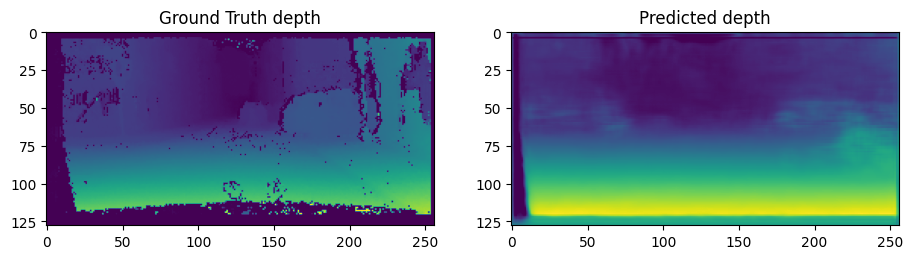

mae: 0.03879835456609726
mre: 127.08850860595703


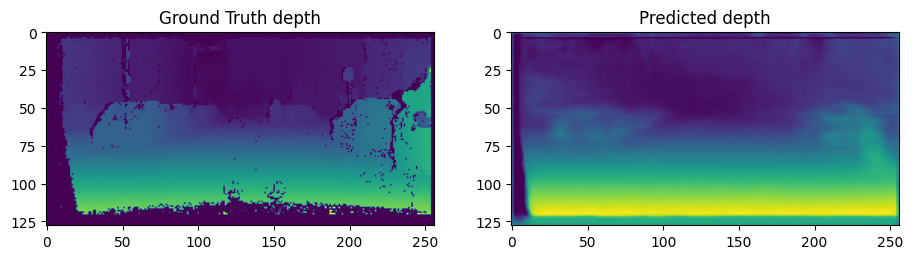

mae: 0.034021276980638504
mre: 35.92290496826172


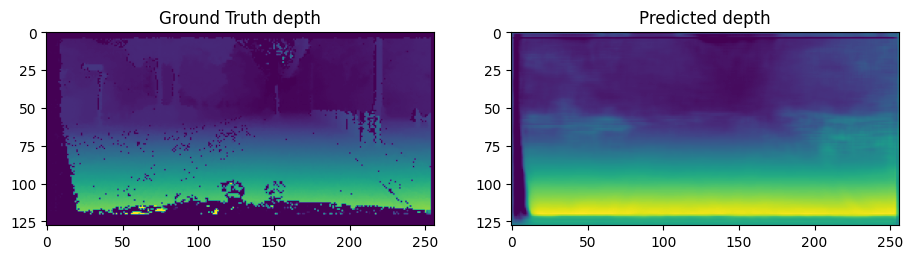

mae: 0.028817936778068542
mre: 61.05838394165039


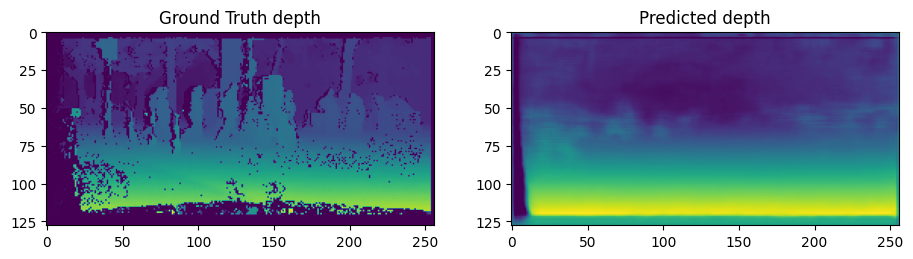

mae: 0.052088577300310135
mre: 40.5313835144043


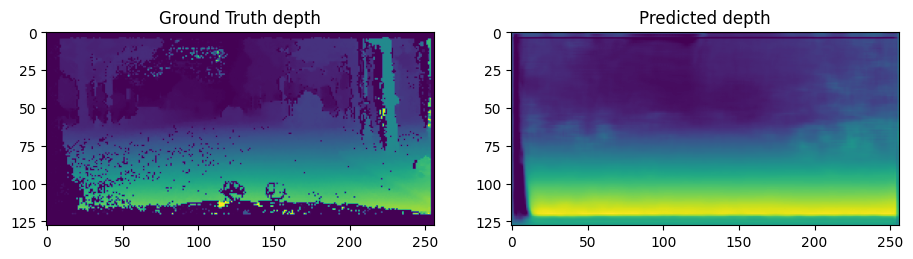

mae: 0.0349823497235775
mre: 113.61865997314453


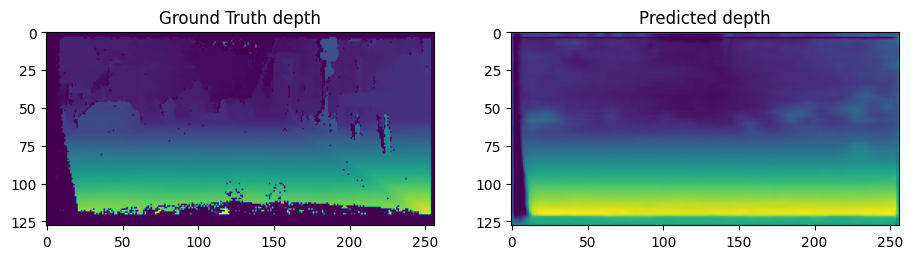

mae: 0.03207063302397728
mre: 31.168109893798828


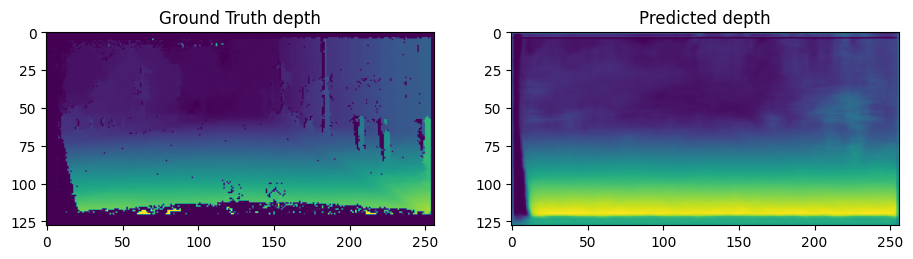

mae: 0.02794700674712658
mre: 43.08822250366211


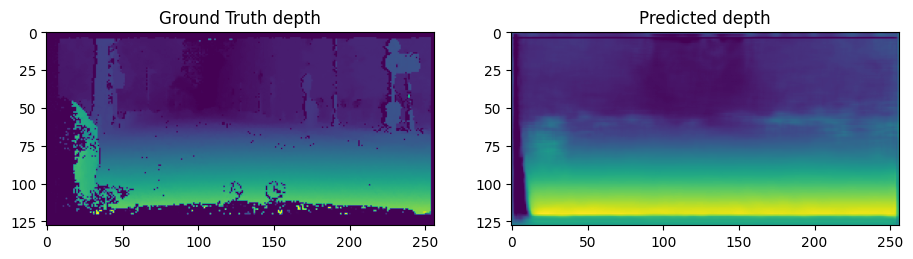

mae: 0.027546631172299385
mre: 97.09797668457031


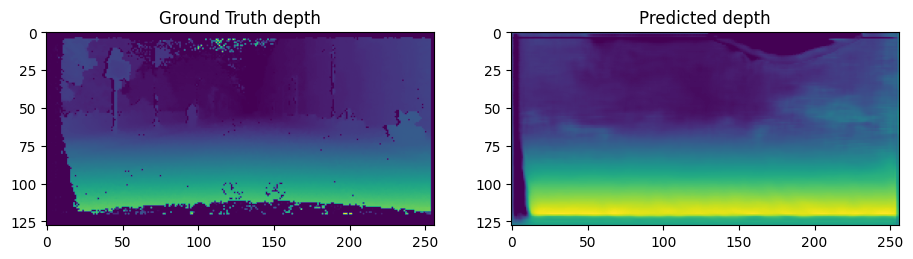

mae: 0.021036460995674133
mre: 61.32389831542969


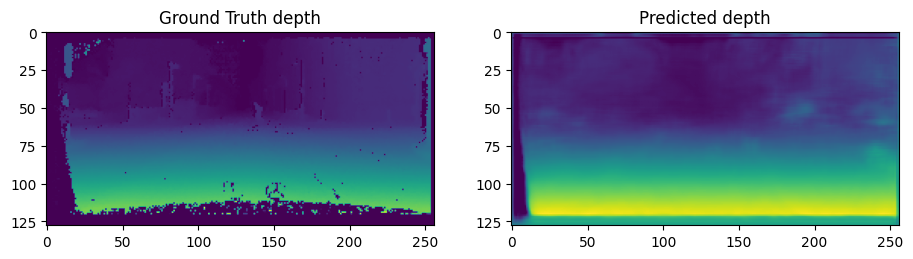

mae: 0.02393602393567562
mre: 55.484046936035156


In [6]:
nresults = 10
id_result = 0
for i, (image, out) in enumerate(val_dl):
    state = visualize_results(model, device, image, out, id_result, nresults, out=True, save_path='../', dataset_str=dataset_string)
    id_result += BATCH_SIZE
    if state:
        break